<a href="https://colab.research.google.com/github/mk1encer/HandsOnML/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [19]:
X,y=mnist['data'],mnist['target']
print(type(X))

<class 'numpy.ndarray'>


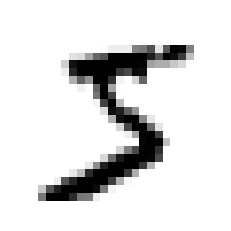

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [29]:
y[0]

'5'

In [30]:
y=y.astype(np.uint8)

In [31]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.9,random_state=100)


X_train, X_test, y_train, y_test=X[:60000],X[60000:],y[:60000],y[60000:]

# 훈련세트를 섞어서 모든 교차검증폴드를 비슷하게 만들어 주는 것이 좋다. 어떤 학습 알고리즘은 샘플 훈서에 민감해서 비슷한 샘플이 연이어 나타나면 성능이 나빠짐.

## *이진 분류기 훈련*

In [32]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

확률적 경사하강법(SGD)로 훈련.
 SGD는 한번에 하나씩 훈련샘플을 독립적으로 처리해서 매우 큰 데이터셋을 효율적으로 처리함(온라인 학습에 적합)

In [34]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
#SGDClassifier는 무작위성을 훈련시 사용하므로 재현하려면 매개변수지정 필요.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [35]:
sgd_clf.predict([some_digit])

array([ True])

In [37]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5,cv=4,scoring='accuracy')

array([0.95766667, 0.9664    , 0.96513333, 0.95366667])

정확도가 95%이상. 다음은 모든 이미지를 5아님으로 분류하는 더미 분류기를 만들어보겠다.

In [38]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X,y=None):
    return self
  
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [40]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

숫자가 0-9 10개이므로 모두5아님으로 분류해도 정확도가 90%가까이 나오는것을 알 수 있음.
**그러므로 정확도는 분류기의 성능측정지표로 적합하지 않다.**

오차행렬을 사용하는 편이 낫다.

오차행렬을 만들기 위해서는 예측값을 만들어야 하는데 테스트세트로 하면 안되고 cross_val_predict()함수를 이용하면 된다.

In [41]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict()함수는 cross_val_score()함수와 동일하게 k-겹 교차검증을 수행하지만 평가점수 반환이 아닌 각 테스트폴드에서 얻은 예측을 반환하므로 모든 훈련세트 샘플에 대해 꺠끗한 예측을 얻을 수 있다.